## Connect to MySQL DB

In [1]:
pw = ''
host = ''
port = ''
db = ''

In [8]:
import mysql.connector
import pandas as pd

In [9]:
cnt = mysql.connector.connect(host=host, user='root', passwd=pw, database=db)

In [10]:
cursor = cnt.cursor(buffered=True)

In [15]:
cursor.execute("DESC telegram;")
result = cursor.fetchall()

In [16]:
result

[('type', b'varchar(100)', 'NO', '', None, ''),
 ('id', b'varchar(100)', 'NO', '', None, ''),
 ('date', b'varchar(100)', 'NO', '', None, ''),
 ('views', b'varchar(100)', 'YES', '', None, ''),
 ('forwards', b'varchar(100)', 'YES', '', None, ''),
 ('replies', b'varchar(100)', 'YES', '', None, '')]

In [21]:
cursor.execute("SELECT * FROM telegram WHERE type = 'moonbird';")
moonbird_tele = cursor.fetchall()

In [23]:
cursor.execute("SELECT * FROM telegram WHERE type = 'bayc';")
bayc_tele = cursor.fetchall()

In [7]:
# query = "DROP TABLE twitter"
# cursor.execute(query)

In [6]:
query = """CREATE TABLE twitter (
    id BIGINT(20) NOT NULL AUTO_INCREMENT PRIMARY KEY,
    created DATETIME NOT NULL,
    replies INT,
    retweets INT,
    likes INT,
    hashtag VARCHAR(255) NOT NULL)"""
cursor.execute(query)

## Add crawled data

In [70]:
pw = ''
host = ''
port = ''
db = ''

In [25]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd

In [26]:
def redundancy_check(sqlEngine, loaded_df):
    dbConnection = sqlEngine.connect()
    fetched_df = pd.read_sql("select * from crawling.twitter", dbConnection)
    # cleaned_df = loaded_df.merge(fetched_df, indicator=True, how='outer').loc[lambda x : x['_merge'] == 'left_only'].iloc[:, :-1]
    
    cleaned_df = loaded_df[~loaded_df.id.isin(fetched_df.id)]
    return cleaned_df
    
def get_table(sqlEngine, table_name=None):
    dbConnection = sqlEngine.connect()
    return pd.read_sql("select * from crawling.{}".format(table_name), dbConnection)

In [4]:
def update_db(tag='moonbirds', pw=None, host=None, port=None, db=None):
    df = pd.read_csv('crawled_{}.csv'.format(tag))

    table_name = 'twitter'
    db_url = 'mysql+pymysql://root:{}@{}:{}/{}'.format(pw, host, port, db)
    sqlEngine = create_engine(db_url, pool_recycle=3600)
    df = redundancy_check(sqlEngine, df)

    dbConnection = sqlEngine.connect()

    try:
        frame = df.to_sql(table_name, dbConnection, if_exists='append', chunksize=1000, index=False)
    except ValueError as vx:
        print(vx)
    except Exception as ex:   
        print(ex)
    else:
        print("Table %s created successfully." % table_name);   
    finally:
        dbConnection.close()

In [5]:
update_db(tag='moonbirds', 
          pw=pw, 
          host=host, 
          port=port, 
          db=db)

Table twitter created successfully.


In [6]:
update_db(tag='bayc', 
          pw=pw, 
          host=host, 
          port=port, 
          db=db)

Table twitter created successfully.


In [7]:
update_db(tag='azuki', 
          pw=pw, 
          host=host, 
          port=port, 
          db=db)

Table twitter created successfully.


In [177]:
db_url = 'mysql+pymysql://root:{}@{}:{}/{}'.format(pw, host, port, db)
sqlEngine = create_engine(db_url, pool_recycle=3600)
telegram = get_table(sqlEngine, 'telegram')

In [178]:
db_url = 'mysql+pymysql://root:{}@{}:{}/{}'.format(pw, host, port, db)
sqlEngine = create_engine(db_url, pool_recycle=3600)
twitter = get_table(sqlEngine, 'twitter')

In [179]:
moon_tele = telegram[telegram['type'] == 'moonbird']
moon_twitter = twitter[twitter['hashtag'] == 'moonbirds']

In [180]:
bayc_tele = telegram[telegram['type'] == 'bayc']
bayc_twitter = twitter[twitter['hashtag'] == 'bayc']

In [181]:
azuki_tele = telegram[telegram['type'] == 'azuki']
azuki_twitter = twitter[twitter['hashtag'] == 'azuki']

In [201]:
def preprocess_fetched(telegram=None, twitter=None):
    if telegram is not None:
        telegram['count'] = 1
    twitter['count'] = 1
    
    twitter['date'] = pd.to_datetime(twitter['created'], format='%Y-%m-%d')
    twitter['date'] = twitter['date'].dt.strftime('%m-%d')
    
    if telegram is not None:
        telegram['date'] = pd.to_datetime(telegram['date'], format='%Y-%m-%d')
        telegram['date'] = telegram['date'].dt.strftime('%m-%d')
        telegram = telegram[telegram['date'].isin(twitter['date'])]
        telegram['views'] = telegram['views'].astype(int)
        telegram['replies'] = telegram['replies'].astype(int)
        telegram['forwards'] = telegram['forwards'].astype(int)
    
        return telegram, twitter

    return twitter

In [ ]:
bayc_tele, bayc_twitter = preprocess_fetched(bayc_tele, bayc_twitter)
azuki_tele, azuki_twitter = preprocess_fetched(azuki_tele, azuki_twitter)

In [203]:
moon_twitter = preprocess_fetched(twitter=moon_twitter)

<ipython-input-201-408c0b110e25>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter['count'] = 1
<ipython-input-201-408c0b110e25>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter['date'] = pd.to_datetime(twitter['created'], format='%Y-%m-%d')
<ipython-input-201-408c0b110e25>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [212]:
import seaborn as sns 
import matplotlib.pyplot as plt


def plot(tele=None, twitter=None, mode='vl', project='bayc'):
    fig, ax = plt.subplots(figsize=(10, 6))
    if tele is not None:
        ax2 = ax.twinx()
    else:
        ax2 = ax

    if mode == 'vl':
        ys = ['views', 'likes']
        text = 'views & likes' if tele is not None else 'likes'
    elif mode == 'r':
        ys = ['replies', 'replies']
        text = 'replies'
    elif mode == 'p':
        ys = ['count', 'count']
        text = 'posts'
    else:
        ys = ['forwards', 'retweets']
        text = 'forward & retweets' if tele is not None else 'retweets'
        
    if tele is not None:
        telegram = tele.groupby(['date']).sum()
        sns.lineplot(data=telegram, x=telegram.index, y=ys[0], estimator=None, label='telegram', ax=ax, legend=False)
    
    twitter = twitter.groupby(['date']).sum()    
    legend = 'full' if tele is None else False
    sns.lineplot(data=twitter, x=twitter.index, y=ys[1], estimator=None, ax=ax2, color='darkorange', label='twitter', legend=legend)

    if tele is not None:
        line_1, label_1 = ax.get_legend_handles_labels()
        line_2, label_2 = ax2.get_legend_handles_labels()

        lines = line_1 + line_2
        labels = label_1 + label_2
        ax.legend(lines, labels, loc=0)
        
    plt.title('{}\n{}'.format(project, text))
    plt.show()

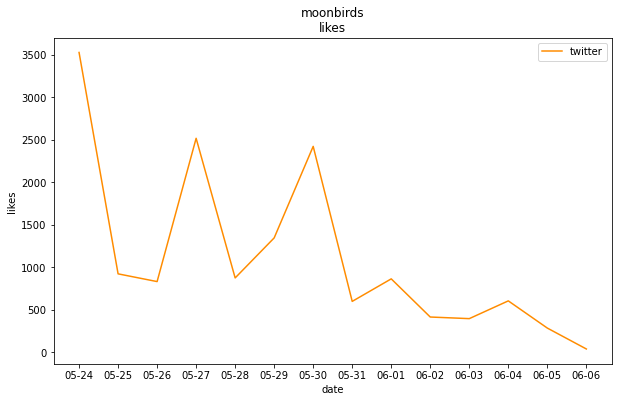

In [213]:
plot(twitter=moon_twitter, mode='vl', project='moonbirds')

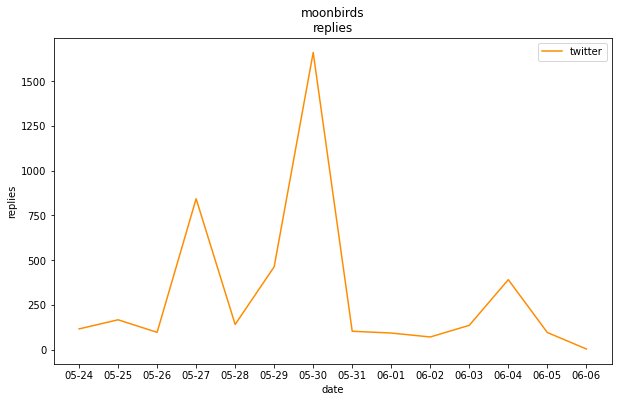

In [214]:
plot(twitter=moon_twitter, mode='r', project='moonbirds')

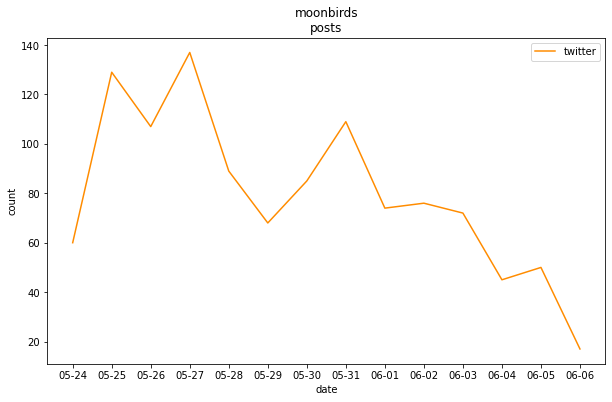

In [215]:
plot(twitter=moon_twitter, mode='p', project='moonbirds')

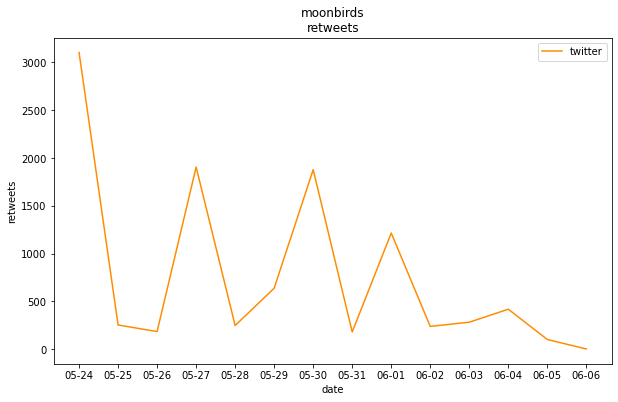

In [216]:
plot(twitter=moon_twitter, mode='fr', project='moonbirds')

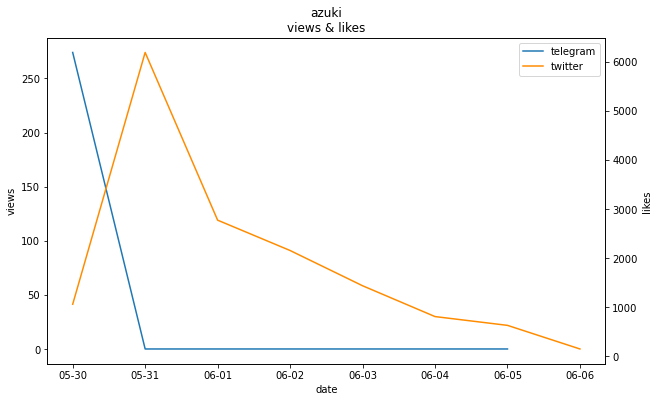

In [200]:
plot(azuki_tele, azuki_twitter, mode='vl', project='azuki')

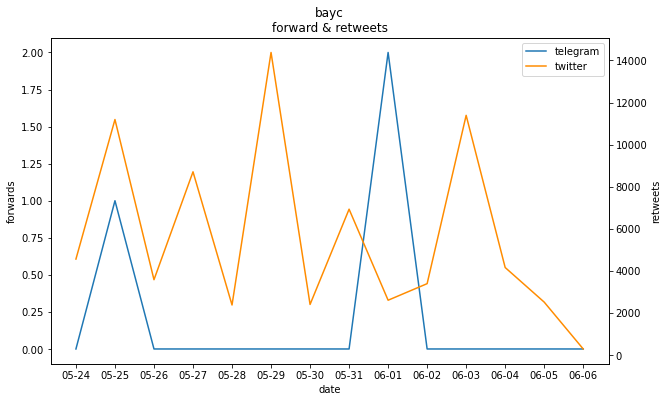

In [197]:
plot(bayc_tele, bayc_twitter, mode='fr', project='bayc')

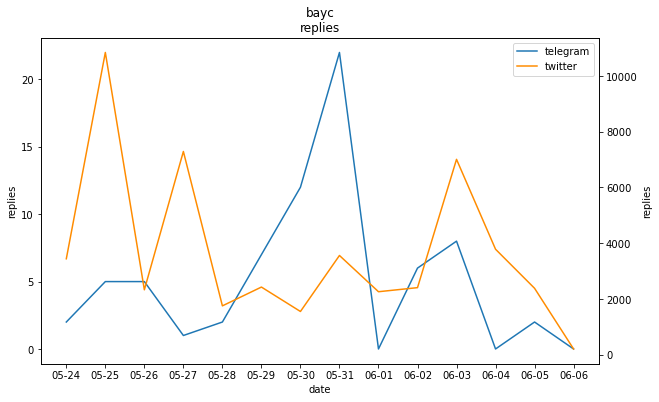

In [198]:
plot(bayc_tele, bayc_twitter, mode='r', project='bayc')

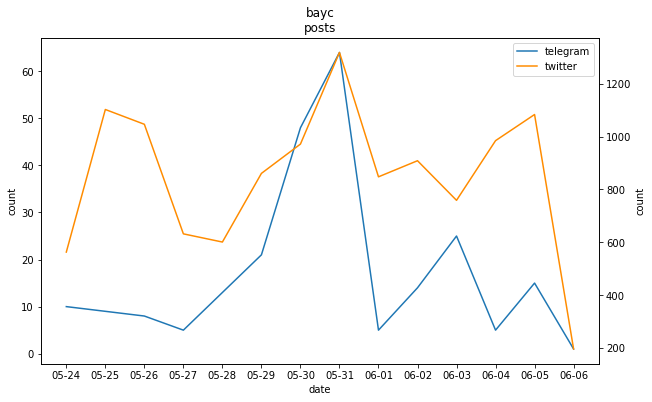

In [199]:
plot(bayc_tele, bayc_twitter, mode='p', project='bayc')